# Cryptocurrency Price Prediction Using Machine Learning

In this project we will train models based on past (historical) price data to forecast future data.<br>
Specifically, we will retrieve the historical data of bitcoin from the [CryptoCompare API](https://min-api.cryptocompare.com) and make predictions on the `close` price.<br>
We will explore the following ML models for this task:
- ARIMA (Autoregressive integrated moving average)
- Linear Regression
- LSTM (Long short-term memory)

We will evaluate the models using mean absolute percentage error (MAPE).

In [1]:
#make all necessary notebook configurations

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.expand_frame_repr', False)

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
#import all necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import cryptocompare

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from pmdarima.arima import ARIMA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [ ]:
#configure CryptoCompare API key

cryptocompare.cryptocompare._set_api_key_parameter('YOUR_API_KEY')

### CryptoCompare API Example
Below is an example of historical data retrieved from the CryptoCompare API.<br>
We can see below that in addition to our target variable (`close`), we have some other features to work with (`high`, `low`, `open`, and `volumefrom`).

In [4]:
raw_data = cryptocompare.get_historical_price_day('BTC', 'USD')
pd.DataFrame.from_dict(raw_data)

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
0,1611187200,35619.60,30067.14,35501.38,125586.98,4.042427e+09,30840.30,direct,
1,1611273600,33857.39,28817.30,30840.30,109210.12,3.418228e+09,33008.02,direct,
2,1611360000,33484.73,31430.15,33008.02,39813.32,1.287619e+09,32107.29,direct,
3,1611446400,33090.99,30957.56,32107.29,33650.76,1.079876e+09,32283.66,direct,
4,1611532800,34881.18,31937.09,32283.66,59529.49,1.989618e+09,32275.27,direct,
...,...,...,...,...,...,...,...,...,...
1436,1735257600,97351.17,93270.34,95680.19,47149.30,4.479655e+09,94170.09,direct,
1437,1735344000,95542.25,94008.53,94170.09,14159.69,1.339744e+09,95140.15,direct,
1438,1735430400,95175.67,92850.44,95140.15,17921.90,1.684135e+09,93564.85,direct,
1439,1735516800,94910.24,91310.52,93564.85,56846.06,5.287498e+09,92646.21,direct,


### Base Model
We will first create a simple model which will predict the future `close` price as the exact same value as the previous day's `close` price.

In [5]:
def base_model(raw_data, train_size, prediction_size):

    historical_data = pd.DataFrame.from_dict(raw_data)
    historical_data['date'] = pd.to_datetime(historical_data['time'], unit='s')
    historical_data.set_index('date',inplace=True)
    historical_data.index.freq = 'D'
    
    dates = []
    actuals = []
    predictions = []
    
    while True:
    
        if len(historical_data) > train_size:
            
            y = historical_data['close'].iloc[-train_size-1:]
            
            y_train = y.iloc[:-1]
            y_test = y.iloc[-1:]
            
            dates.append(y_test.index.values[0])
            actuals.append(y_test.values[0])
            predictions.append(y_train.values[-1])
    
            historical_data.drop(historical_data.tail(1).index, inplace=True)

            if (len(dates) == prediction_size):
                break

        else:
            
            break
    
    results = pd.DataFrame({'date': dates, 'actual': actuals, 'prediction': predictions})
    results.set_index('date', inplace=True)
    results = results.iloc[::-1]
    
    return results

def run_base_model(ticker):

    train_size = 1

    prediction_size = 30
    
    raw_data = cryptocompare.get_historical_price_day(ticker, 'USD')

    start_time = time.time()
        
    results = base_model(raw_data, train_size, prediction_size)

    end_time = time.time()

    MAPE = mean_absolute_percentage_error(results['actual'], results['prediction'])
    
    run_time = round(end_time - start_time, 1)

    plt.figure(figsize=(14,3))
    plt.title(f'{ticker}/USD, Base Model')
    plt.ylabel('Close Price')
    plt.plot(results)
    plt.legend(results.columns)
    plt.grid()
    plt.show()
   
    results = pd.DataFrame({'Model': 'Base',
                            'Train Size': train_size,
                            'Predictions': prediction_size,
                            'MAPE': MAPE,
                            'Run Time (s)': run_time}, index=[0])
    
    return results

#### Base model results:

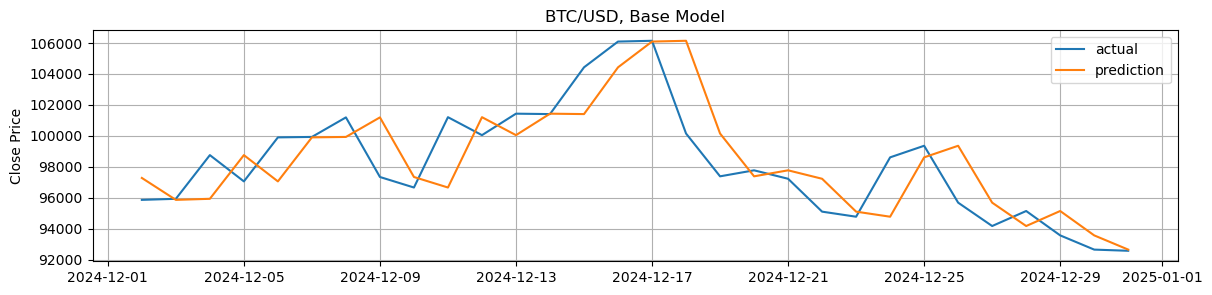

  Model  Train Size  Predictions      MAPE  Run Time (s)
0  Base           1           30  0.017576           0.0


In [6]:
base_model_results = run_base_model('BTC')
print(base_model_results)

### ARIMA Model
ARIMA is a common ML model used in time series problems. As such, we are able to easly apply it to this task.<br>
We are only able to use a single feature to make the prediction, in this case, the `close` price, which is our target variable. This is due to the fact that using other features in an ARIMA model requires that the future values of those additional features are known at training time.

In [7]:
def arima_model(raw_data, train_size, prediction_size):

    historical_data = pd.DataFrame.from_dict(raw_data)
    historical_data['date'] = pd.to_datetime(historical_data['time'], unit='s')
    historical_data.set_index('date',inplace=True)
    historical_data.index.freq = 'D'
    
    dates = []
    actuals = []
    predictions = []
    
    while True:
    
        if len(historical_data) > train_size:
            
            y = historical_data['close'].iloc[-train_size-1:]
            
            y_train = y.iloc[:-1]
            y_test = y.iloc[-1:]

            model = ARIMA((0, 1, 0)).fit(y_train)
            
            dates.append(y_test.index.values[0])
            actuals.append(y_test.values[0])
            predictions.append(model.predict(1).values[0])
    
            historical_data.drop(historical_data.tail(1).index, inplace=True)

            if (len(dates) == prediction_size):
                break

        else:
            
            break
    
    results = pd.DataFrame({'date': dates, 'actual': actuals, 'prediction': predictions})
    results.set_index('date', inplace=True)
    results = results.iloc[::-1]
    
    return results

def run_arima_model(ticker):

    results = []

    train_sizes = []

    prediction_size = 30

    MAPEs = []

    run_times = []
    
    raw_data = cryptocompare.get_historical_price_day(ticker, 'USD')
        
    for train_size in [60, 120, 300]:

        start_time = time.time()
    
        result = arima_model(raw_data, train_size, prediction_size)
        end_time = time.time()

        results.append(result)

        train_sizes.append(train_size)

        MAPE = mean_absolute_percentage_error(result['actual'], result['prediction'])
        MAPEs.append(MAPE)
        
        run_time = round(end_time - start_time, 1)
        run_times.append(run_time)
   
    df = pd.DataFrame({'Model': 'ARIMA',
                       'Train Size': train_sizes,
                       'Predictions': prediction_size,
                       'MAPE': MAPEs,
                       'Run Time (s)': run_times})

    best_result = results[df['MAPE'].idxmin()]

    plt.figure(figsize=(14,3))
    plt.title(f'{ticker}/USD, Best ARIMA Model')
    plt.ylabel('Close Price')
    plt.plot(best_result)
    plt.legend(best_result.columns)
    plt.grid()
    plt.show()
    
    return df

#### ARIMA model results:

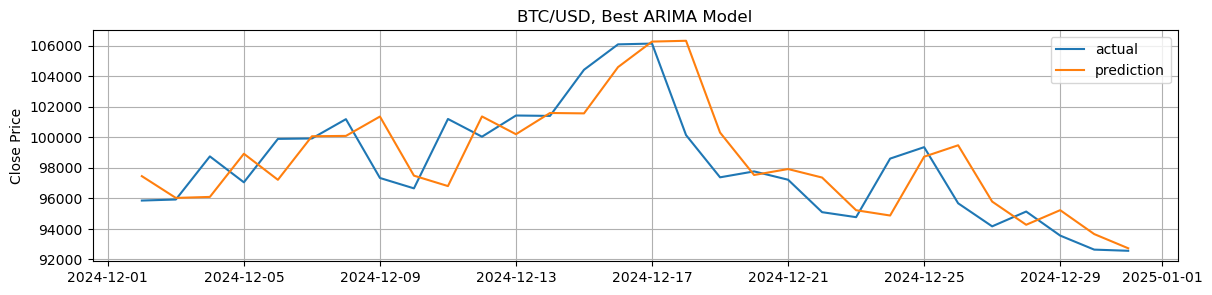

   Model  Train Size  Predictions      MAPE  Run Time (s)
0  ARIMA          60           30  0.019112           0.5
1  ARIMA         120           30  0.018435           0.5
2  ARIMA         300           30  0.017898           0.6


In [8]:
arima_model_results = run_arima_model('BTC')
print(arima_model_results)

### Linear Regression and LSTM Models
These models are not natively designed for time series, so we will need to use the window sliding to convert this time series problem into a regression problem.<br>
We will use a window size of 60 for the test runs.

These models don't have the limitation of predicting based only on the target variable.
- We will first run the test using `close` as the only input feature.
- Second, we will use `close` and `volumefrom`.
- Finally, we will use all available features (`close`, `volumefrom`, `high`, `low`, and `open`).

In [9]:
def linear_model(raw_data, train_size, window_size, features, prediction_size):

    historical_data = pd.DataFrame.from_dict(raw_data)
    historical_data['date'] = pd.to_datetime(historical_data['time'], unit='s')
    historical_data.set_index('date',inplace=True)

    historical_data = historical_data[features]

    for i in range(window_size):

        for feature in features:

            historical_data[f'{feature}_{i+1}'] = historical_data[feature].shift(i+1)

    historical_data = historical_data.dropna()

    for feature in features:

        if feature != 'close': #we need to keep 'close' to assign as y

            historical_data = historical_data.drop(feature, axis=1)
    
    dates = []
    actuals = []
    predictions = []
    
    while True:
    
        if len(historical_data) > train_size:
            
            X = historical_data.drop(['close'], axis=1).iloc[-train_size-1:]
            y = historical_data['close'].iloc[-train_size-1:]
            
            X_train = X.iloc[:-1]
            X_test = X.iloc[-1:]
            
            y_train = y.iloc[:-1]
            y_test = y.iloc[-1:]

            model = LinearRegression().fit(X_train, y_train)

            date = historical_data.index.values[-1]

            actual = y_test.values[0]
            
            prediction = model.predict(X_test)[0]
            
            dates.append(date)
            actuals.append(actual)
            predictions.append(prediction)
    
            historical_data.drop(historical_data.tail(1).index, inplace=True)

            if (len(dates) == prediction_size):
                    break
    
        else:
            
            break
    
    results = pd.DataFrame({'date': dates, 'actual': actuals, 'prediction': predictions})
    results.set_index('date', inplace=True)
    results = results.iloc[::-1]
    
    return results

def lstm_model(raw_data, train_size, window_size, features, prediction_size):

    historical_data = pd.DataFrame.from_dict(raw_data)
    historical_data['date'] = pd.to_datetime(historical_data['time'], unit='s')
    historical_data.set_index('date',inplace=True)
    historical_data = historical_data[features]
    
    dates = []
    actuals = []
    predictions = []
    
    while True:
    
        if len(historical_data) > train_size+window_size:

            scaler = MinMaxScaler(feature_range=(0, 1))
            scaled_historical_data = scaler.fit_transform(historical_data)
            
            scaler2 = MinMaxScaler(feature_range=(0, 1))
            scaled_close = scaler2.fit_transform(historical_data[['close']])
            
            X = []
            y = []
            for i in range(train_size):
                X.append(scaled_historical_data[i-window_size-train_size:i-train_size])
                y.append(scaled_close[i-train_size])
            
            X = np.array(X)
            y = np.array(y)
            
            X_train = X[:-1]
            X_test = X[-1:]
            
            y_train = y[:-1]
            y_test = y[-1:]
            
            model = Sequential()
            model.add(LSTM(64, input_shape=(window_size, len(features))))
            model.add(Dense(1))
            
            model.compile(loss='mape', metrics=['mape'])
            
            history = model.fit(
                X_train, y_train,
                epochs = 2,
                verbose = 0
            )
            
            date = historical_data.index.values[-1]
            
            actual = historical_data['close'].iloc[-1]
            
            prediction = model.predict(X_test, verbose=0)
            prediction = scaler2.inverse_transform(prediction).reshape(-1)[0]
            
            dates.append(date)
            actuals.append(actual)
            predictions.append(prediction)
    
            historical_data.drop(historical_data.tail(1).index, inplace=True)

            if (len(dates) == prediction_size):
                break
    
        else:
            
            break
    
    results = pd.DataFrame({'date': dates, 'actual': actuals, 'prediction': predictions})
    results.set_index('date', inplace=True)
    results = results.iloc[::-1]
    
    return results

def run_regression_models(ticker):

    results = []
    
    models = []

    train_sizes = []

    window_size = 60

    prediction_size = 3

    feature_sets = [
        ['close'],
        ['close', 'volumefrom'],
        ['close', 'volumefrom', 'high', 'low', 'open']
    ]
    features = []

    MAPEs = []

    run_times = []
    
    raw_data = cryptocompare.get_historical_price_day(ticker, 'USD')

    for model in ['LinearRegression', 'LSTM']:
        
        for train_size in [60, 120, 300]:

            for feature_set in feature_sets:
    
                start_time = time.time()
            
                match model:
                
                    case 'LinearRegression':
                        result = linear_model(raw_data, train_size, window_size, feature_set, prediction_size)
                    case 'LSTM':
                        result = lstm_model(raw_data, train_size, window_size, feature_set, prediction_size)
        
                end_time = time.time()

                results.append(result)
        
                models.append(model)
    
                train_sizes.append(train_size)

                features.append(len(feature_set))
        
                MAPE = mean_absolute_percentage_error(result['actual'], result['prediction'])
                MAPEs.append(MAPE)
                
                run_time = round(end_time - start_time, 1)
                run_times.append(run_time)
   
    df = pd.DataFrame({'Model': models,
                       'Train Size': train_sizes,
                       'Window Size': window_size,
                       'Features': features,
                       'Predictions': prediction_size,
                       'MAPE': MAPEs,
                       'Run Time (s)': run_times})

    for model in ['LinearRegression', 'LSTM']:

        best_result = results[df[df['Model'] == model]['MAPE'].idxmin()]
    
        plt.figure(figsize=(14,3))
        plt.title(f'{ticker}/USD, Best {model} Model')
        plt.ylabel('Close Price')
        plt.plot(best_result)
        plt.legend(best_result.columns)
        plt.grid()
        plt.show()

    return df

#### Linear Regression and LSTM model results:

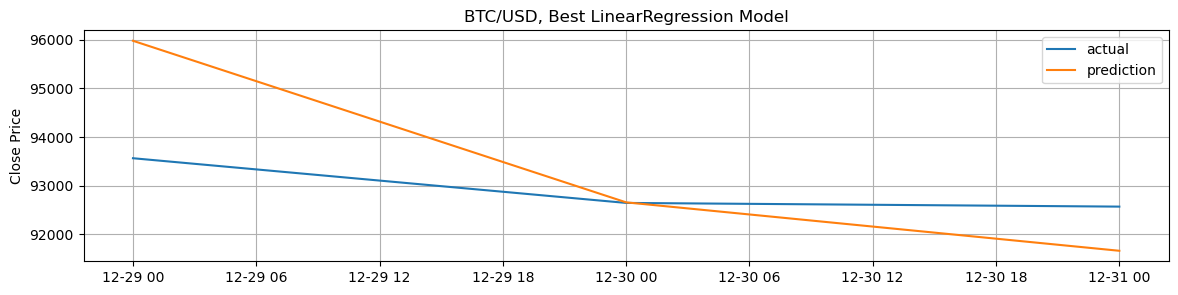

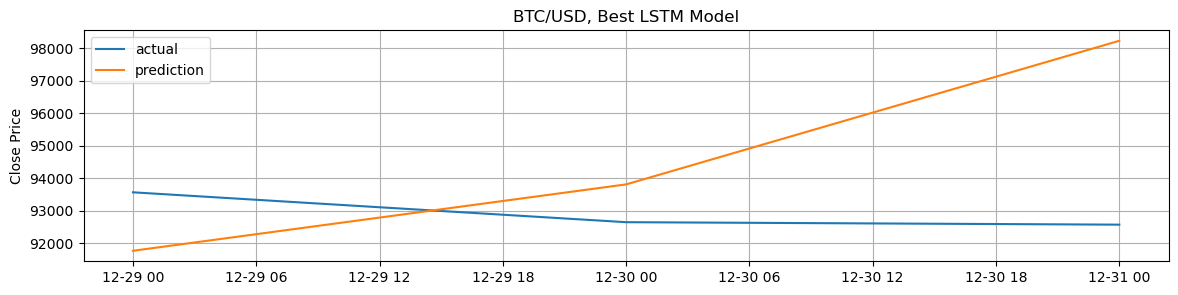

               Model  Train Size  Window Size  Features  Predictions      MAPE  Run Time (s)
0   LinearRegression          60           60         1            3  0.143724           0.1
1   LinearRegression          60           60         2            3  0.065770           0.1
2   LinearRegression          60           60         5            3  0.027507           0.3
3   LinearRegression         120           60         1            3  0.023549           0.1
4   LinearRegression         120           60         2            3  0.258938           0.1
5   LinearRegression         120           60         5            3  0.052430           0.3
6   LinearRegression         300           60         1            3  0.011910           0.1
7   LinearRegression         300           60         2            3  0.022815           0.1
8   LinearRegression         300           60         5            3  0.031126           0.5
9               LSTM          60           60         1            3  

In [10]:
regression_models_results = run_regression_models('BTC')
print(regression_models_results)

### Summary
Below we will visualize the results of the best version of each type of model.

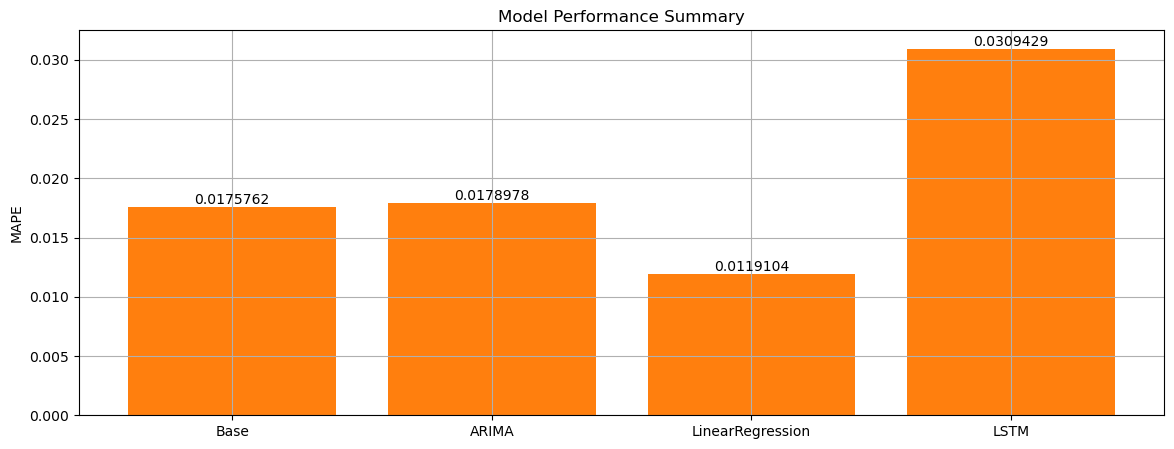

              Model  Train Size  Predictions      MAPE  Run Time (s)  Window Size  Features
0              Base           1           30  0.017576           0.0          NaN       NaN
1             ARIMA         300           30  0.017898           0.6          NaN       NaN
2  LinearRegression         300            3  0.011910           0.1         60.0       1.0
3              LSTM         300            3  0.030943          11.4         60.0       1.0


In [11]:
results = pd.concat([base_model_results, arima_model_results, regression_models_results], ignore_index=True, sort=False)
best_results = results.loc[results.groupby('Model')['MAPE'].idxmin()].sort_index().reset_index(drop=True)

plt.figure(figsize=(14,5))
plt.title('Model Performance Summary')
plt.ylabel('MAPE')
plt.bar(best_results['Model'], best_results['MAPE'])
plt.bar_label(plt.bar(best_results['Model'], best_results['MAPE']))
plt.grid()
plt.show()

print(best_results)